# Comparing time series predictions of COVID-19 deaths

### Importing Libraries

In [1]:
!pip install pmdarima

In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
warnings.filterwarnings('ignore')

### Load Data

In [4]:
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')

In [5]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88


In [6]:
# Get deaths
d = deaths_df.loc[:, '1/22/20':]

In [7]:
d = d.transpose()

In [8]:
# Get row-wise sum
d = d.sum(axis=1)

In [9]:
d

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
8/12/20    743989
8/13/20    750230
8/14/20    760374
8/15/20    765718
8/16/20    769904
Length: 208, dtype: int64

In [10]:
d = d.to_list()

In [11]:
# Create New dataframe
dataset = pd.DataFrame(columns=['ds', 'y'])

In [12]:
# Get the Dates
dates = list(deaths_df.columns[4:])

In [13]:
# convert dates to date-time format
dates = list(pd.to_datetime(dates))

In [14]:
dataset['ds'] = dates
dataset['y'] = d

In [15]:
# make the dates the index
dataset=dataset.set_index('ds')

In [16]:
dataset.head()

,y
ds,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56


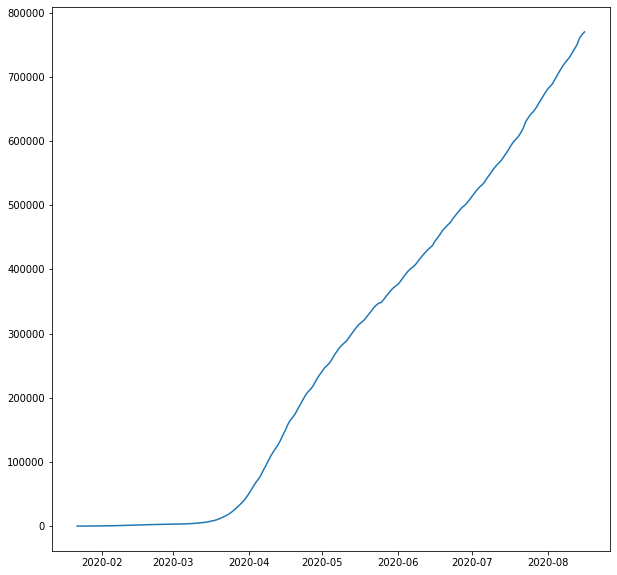

In [17]:
# Plot the daily number of deaths

plt.figure(figsize=(10, 10))
plt.plot(dataset)
plt.savefig('Cummulative daily deaths', bbox_inches='tight', transparent=False)

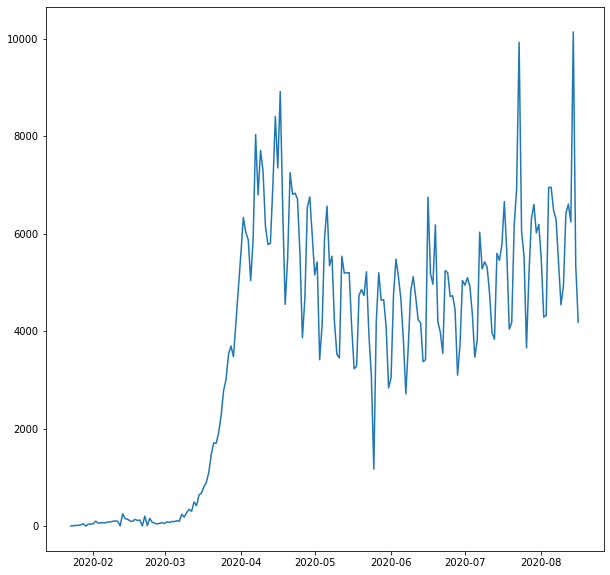

In [18]:
# Plot the Daily Increase in Deaths

plt.figure(figsize=(10, 10))
plt.plot(dataset.diff())
plt.savefig('Daily deaths', bbox_inches='tight', transparent=False)

In [19]:
dataset = dataset.diff()

In [20]:
# Remove first day
dataset = dataset.loc['2020-01-23':'2020-08-13']

In [24]:
# Split Data

start_date = '2020-07-31'

train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

### Forecasting using SARIMAX(Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)

In [29]:
# use auto_Arima to find best hyper parameters

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3111.971, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.414, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3128.118, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3089.597, Time=0.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3116.490, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.847, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.308, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.720, Time=0.73 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=0.49 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

In [25]:
model = SARIMAX(train, order=(2, 1, 3))

In [26]:
results = model.fit(disp=True)

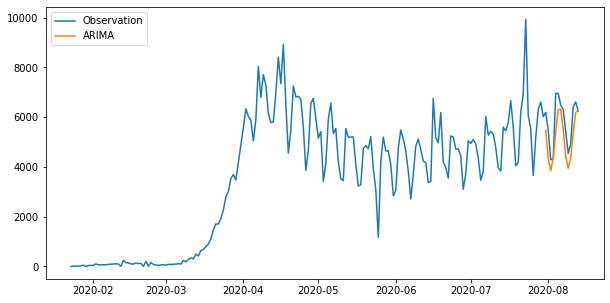

In [27]:
# Predict and Compare with original Results

sarimax_prediction = results.predict(
    start=start_date, end='2020-08-13', dynamic=False)
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('SARIMAX prediction', bbox_inches='tight', transparent=False)

In [28]:
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE =  650.6154682219609


### Forecasting using Facebook's Prophet

In [30]:
train['ds'] = train.index.values

In [31]:
# Create new Prophet object and fit

m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = m.make_future_dataframe(periods=dataset.shape[0]-train.shape[0]) # Find number of days to predict
prophet_prediction = m.predict(future)

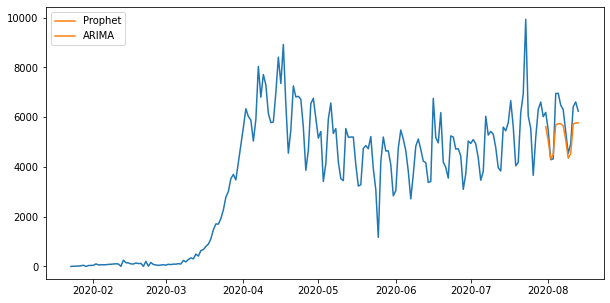

In [29]:
# Predict and Compare with original Results

plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset, label='Observation')
l1, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1, l2])
plt.savefig('Prophet predictions',
            bbox_inches='tight', transparent=False)

In [33]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= start_date]
print('Prophet MAE = ', mean_absolute_error(prophet_future, test))

Prophet MAE =  571.8872860781038


### Preprocess Data for XGBOOST and Neural Network

In [37]:
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y

In [38]:
# Create Train and Test Datasets

X_train, y_train = featurize(
    dataset.loc[dataset.index < pd.to_datetime(start_date)])
X_test, y_test = featurize(
    dataset.loc[dataset.index >= pd.to_datetime(start_date)])

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
### Apply the scaling to both the training and test 

scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

### Train XGBOOST and Neural Network models

In [41]:
XGBOOST_model = XGBRegressor(n_estimators=7)

In [42]:
XGBOOST_model.fit(scaled_train, y_train,
                  eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                  verbose=True)
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

[17:23:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3926.27	validation_1-rmse:5364.15
[1]	validation_0-rmse:3563.2	validation_1-rmse:4909.52
[2]	validation_0-rmse:3234.76	validation_1-rmse:4536.32
[3]	validation_0-rmse:2939.88	validation_1-rmse:4200.33
[4]	validation_0-rmse:2674.4	validation_1-rmse:3862.47
[5]	validation_0-rmse:2439.07	validation_1-rmse:3591.74
[6]	validation_0-rmse:2223.52	validation_1-rmse:3261.25


In [43]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE =  3194.1184430803573


In [44]:
# BasicFeed-Forward Neural Network

NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=210, verbose=1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/210
6/6 [==============================] - 1s 39ms/step - loss: 3521.5349 - val_loss: 5792.8135
Epoch 2/210
6/6 [==============================] - 0s 8ms/step - loss: 3521.4922 - val_loss: 5792.8228
Epoch 3/210
6/6 [==============================] - 0s 7ms/step - loss: 3521.4495 - val_loss: 5792.7603
Epoch 4/210
6/6 [==============================] - 0s 10ms/step - loss: 3521.4072 - val_loss: 5792.7095
Epoch 5/210
6/6 [==============================] - 0s 6ms/step - loss: 3521.3625 - val_loss: 5792.6133
Epoch 6/210
6/6 [==============================] - 0s 6ms/step - loss: 3521.3147 - val_loss: 5792.5151
Epoch 7/210
6/6 [==============================] - 0s 5ms/step - loss: 3521.2629 - val_loss: 5792.3779
Epoch 8/210
6/6 [==============================] - 0s 6ms/step - loss: 3521.2053 - val_loss: 5792.2446
Epoch 9/210
6/6 [==============================] - 0s 6ms/step - loss: 3521.1418 - val_loss: 5792.0835
Epoch 10/210
6/6 [==============================] - 0s 7ms/step - loss:

### Assess All Models

In [45]:
# Compare all the MAE values.

print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))
print('Prophet MAE = ', mean_absolute_error(prophet_future, test))
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))
print('NN MAE = ', mean_absolute_error(NN_prediction, test))

XGBOOST MAE =  3194.1184430803573
Prophet MAE =  571.8872860781038
SARIMAX MAE =  650.6154682219609
NN MAE =  724.5163922991071


<Figure size 1440x1440 with 0 Axes>

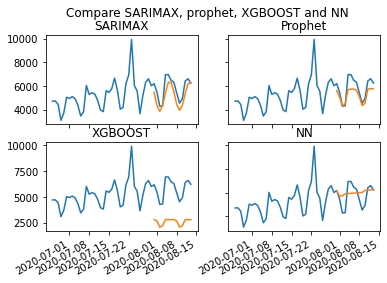

In [46]:
# Visualize all Model Predictions vs the Actual Value

XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index

plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(dataset.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()

# Auto rotates the date labels on the x-axis.
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)